<a href="https://colab.research.google.com/github/karans98/LSTM_Forecasting/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [2]:
# 1. Data Preparation
data = pd.read_csv('https://fetch-hiring.s3.amazonaws.com/machine-learning-engineer/receipt-count-prediction/data_daily.csv', parse_dates = ['# Date'], index_col = '# Date')
data.head()

,Receipt_Count
# Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289


In [3]:
data.shape

(365, 1)

<Axes: xlabel='# Date'>

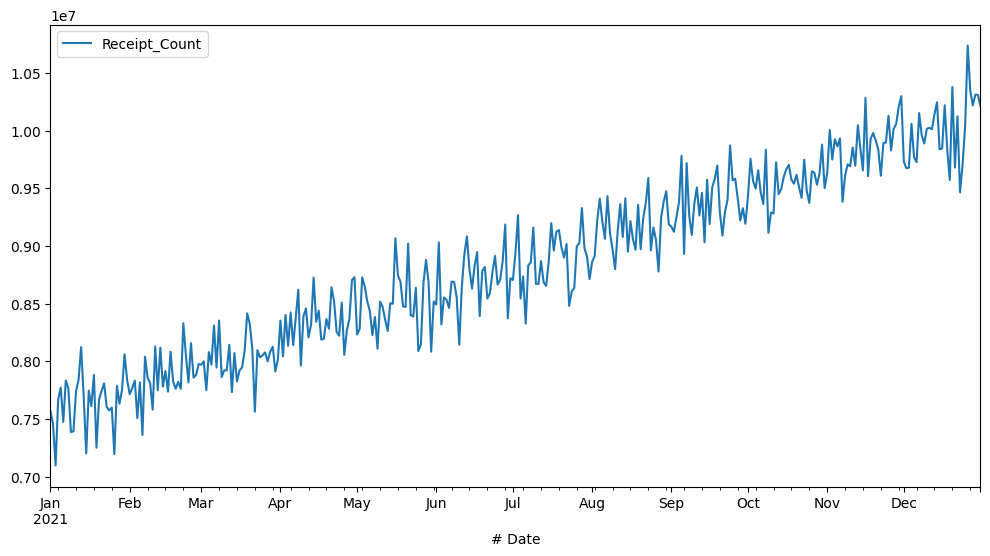

In [4]:
data.plot(figsize=(12,6))

In [5]:
data_diff = data.diff().dropna()

In [6]:
data_diff.head()

,Receipt_Count
# Date,
2021-01-02,-109242.0
2021-01-03,-360110.0
2021-01-04,570749.0
2021-01-05,105126.0
2021-01-06,-297969.0


ADF Statistic:  -8.889819175651198
p-value:  1.251287215422354e-14


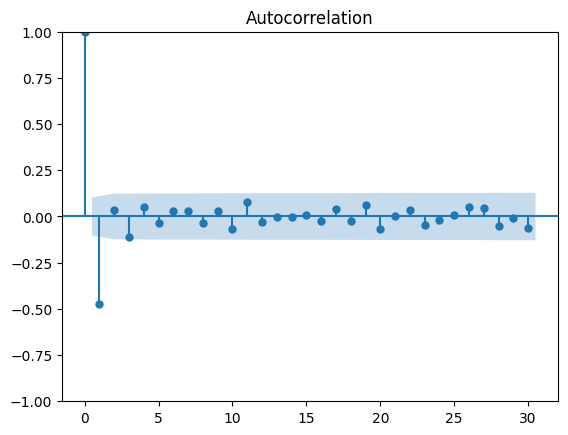

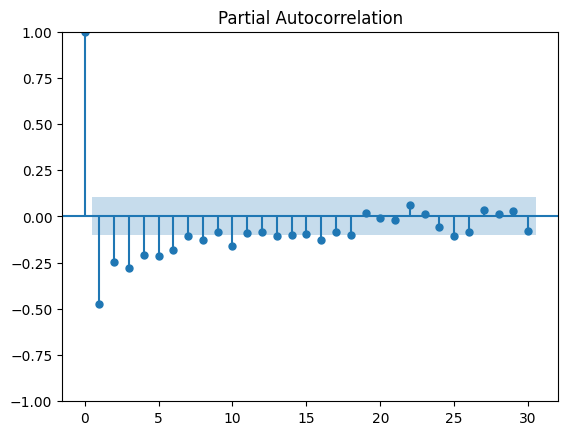

In [7]:
#PACF plot:
result = adfuller(data_diff)
print('ADF Statistic: ',result[0])
print('p-value: ',result[1])
plot_acf(data_diff, lags=30)
plot_pacf(data_diff, lags=30)
plt.show()

In [8]:
train = data_diff.iloc[:-92] # First 9 months
test = data_diff.iloc[-92:] # Last 3 months

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train.values.reshape(-1,1))
scaled_train = scaler.transform(train.values.reshape(-1,1))
scaled_test = scaler.transform(test.values.reshape(-1,1))

In [10]:
#Time series Generator
look_back = 10
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=look_back, batch_size=1)

In [11]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(30, input_shape=(look_back, n_features)))
model.add(Dense(1))

learning_rate = 0.01
adam_optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3871 (15.12 KB)
Trainable params: 3871 (15.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = model.fit(generator, epochs=100)

Epoch 1/100
262/262 [==============================] - 7s 12ms/step - loss: 0.1170
Epoch 2/100
262/262 [==============================] - 3s 10ms/step - loss: 0.0975
Epoch 3/100
262/262 [==============================] - 3s 10ms/step - loss: 0.1005
Epoch 4/100
262/262 [==============================] - 3s 10ms/step - loss: 0.0967
Epoch 5/100
262/262 [==============================] - 3s 10ms/step - loss: 0.0995
Epoch 6/100
262/262 [==============================] - 1s 5ms/step - loss: 0.0941
Epoch 7/100
262/262 [==============================] - 2s 6ms/step - loss: 0.0945
Epoch 8/100
262/262 [==============================] - 2s 7ms/step - loss: 0.0903
Epoch 9/100
262/262 [==============================] - 2s 6ms/step - loss: 0.0945
Epoch 10/100
262/262 [==============================] - 2s 6ms/step - loss: 0.0908
Epoch 11/100
262/262 [==============================] - 1s 5ms/step - loss: 0.0898
Epoch 12/100
262/262 [==============================] - 2s 6ms/step - loss: 0.0955
Epoch 13

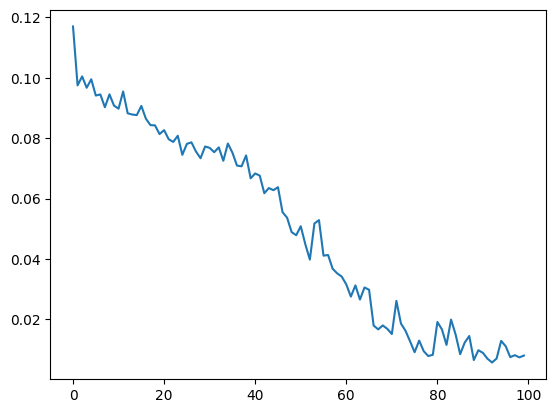

In [14]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [15]:
model.save('forecast_model')

In [16]:
from keras.models import load_model

pred_model = load_model('forecast_model')

In [17]:
def forecasted_values(no_of_days, train_data, last_known_value, n_input, n_features = 1):
  test_predictions = []
  first_eval_batch = train_data[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))

  for i in range(no_of_days):
      current_pred = pred_model.predict(current_batch)[0]
      test_predictions.append(current_pred)
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

  test_predict_scaled = scaler.inverse_transform(test_predictions)

  forecasted_values = [last_known_value]

  for predicted_difference in test_predict_scaled:
      next_value = forecasted_values[-1] + predicted_difference
      forecasted_values.append(next_value)

  return forecasted_values

In [18]:
last_known_value = data.iloc[-93]['Receipt_Count']
test_predicts = forecasted_values(len(test), scaled_train, last_known_value, look_back)

1/1 [==============================] - 0s 22ms/step


In [19]:
actuals = data.iloc[-92:]

In [20]:
mape = np.mean(np.abs((np.array(actuals['Receipt_Count']) - np.array(test_predicts[1:])) / np.array(actuals['Receipt_Count']))) * 100

mape

3.065406064480555

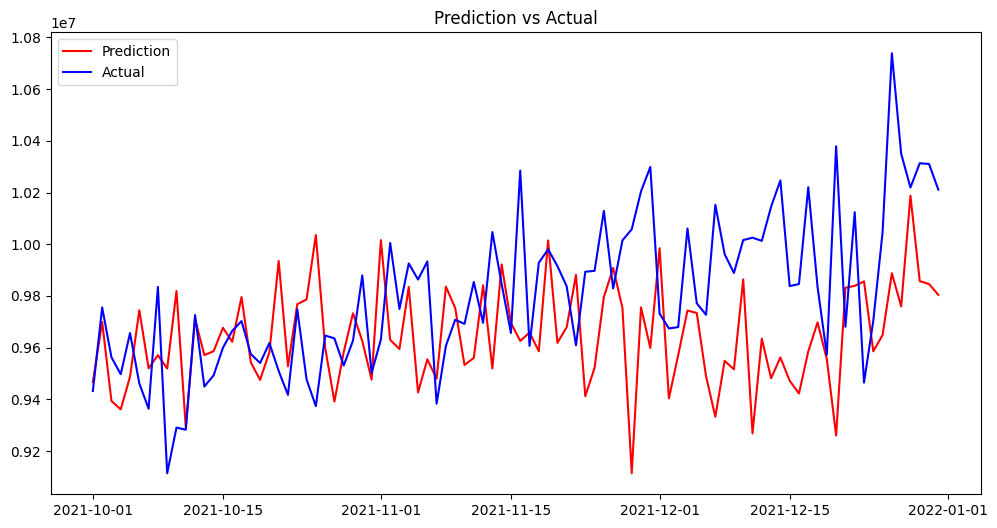

In [21]:
plt.figure(figsize=(12,6))
plt.plot(actuals.index, test_predicts[1:], label='Prediction', color='red')
plt.plot(actuals.index, actuals['Receipt_Count'], label='Actual', color='blue')
#plt.plot(data.index, data['Receipt_Count'], label='Data', color='green')
plt.legend(loc='best')
plt.title('Prediction vs Actual')
plt.show()

In [22]:
last_known_value = data.iloc[-1]['Receipt_Count']
forecast_2022 = forecasted_values(365, scaled_test, last_known_value, look_back)


1/1 [==============================] - 0s 23ms/step


In [23]:
forecast_2022 = [i[0] for i in forecast_2022[1:]]
date_index_2022 = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
forecast_df = pd.DataFrame({'Date': date_index_2022, 'Receipt_Count': forecast_2022})
forecast_df.set_index('Date', inplace=True)
monthly_sum = forecast_df.resample('M').sum()

In [24]:
monthly_sum

,Receipt_Count
Date,
2022-01-31,3.163118e+08
2022-02-28,2.902410e+08
2022-03-31,3.257218e+08
2022-04-30,3.175813e+08
2022-05-31,3.260405e+08
2022-06-30,3.223320e+08
2022-07-31,3.431764e+08
2022-08-31,3.484334e+08
2022-09-30,3.404102e+08


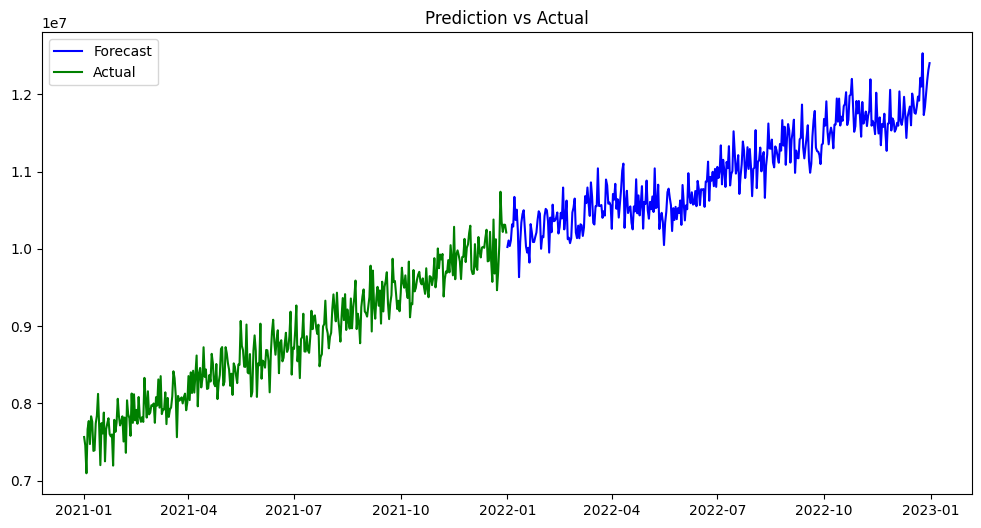

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(date_index_2022, forecast_2022, label='Forecast', color='blue')
plt.plot(data.index, data['Receipt_Count'], label='Actual', color='green')
plt.legend(loc='best')
plt.title('Prediction vs Actual')
plt.show()